### Loading dependent libraries

In [1]:
import cv2
import os
import numpy as np
import json
import zipfile
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

In [3]:
#!wget https://images.fineartamerica.com/images-medium-large-5/central-park-balloon-man-madeline-ellis.jpg
im = cv2.imread("central-park-balloon-man-madeline-ellis.jpg")
DatasetCatalog.clear()

In [4]:
# Predict and annotate the image and plot it
def plot_predict(cfg, im):
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2.imshow('Prediction', v.get_image()[:, :, ::-1])
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.imshow(v.get_image()[..., ::-1])

### Prediction of test image using COCO Keypoint Person Detector model with a ResNet50-FPN base network

In [5]:
# Create model config
cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_1x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
#cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_1x/137261548/model_final_04e291.pkl"
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"

/home/praxs/miniconda3/envs/dl/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/praxs/miniconda3/envs/dl/lib/python3.6/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


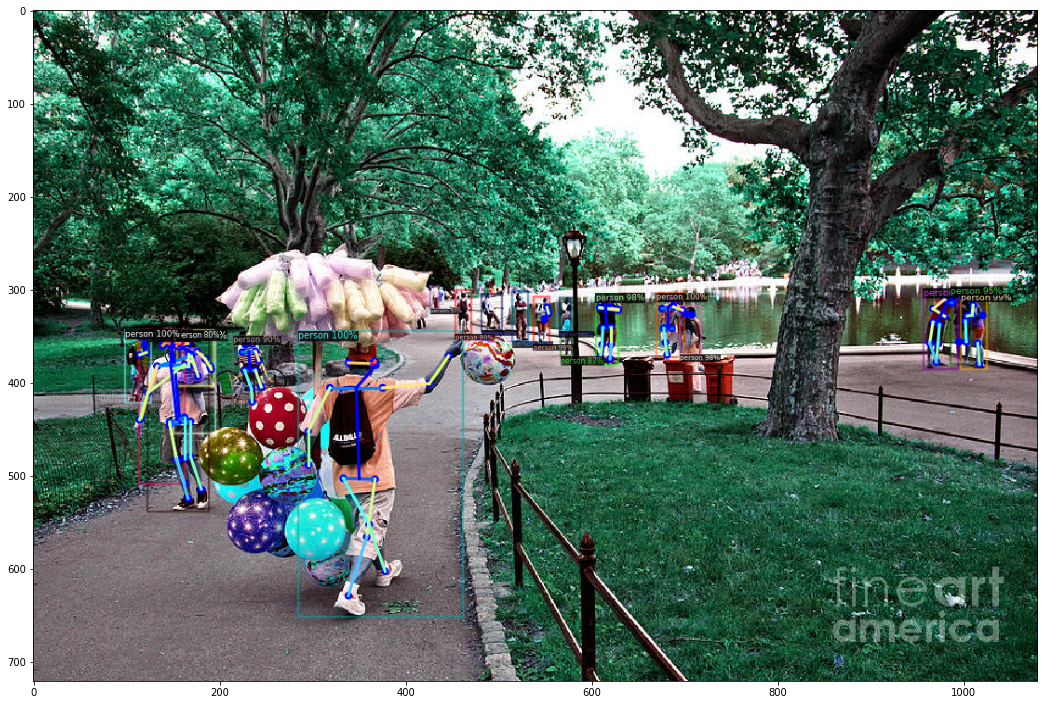

In [6]:
plot_predict(cfg, im)

### Prediction of test image using COCO Instance Segmentation model using Mask R-CNN model with ResNet50-FPN backbone

In [7]:
# Create model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

In [8]:
plot_predict(cfg, im)

### Using above pre-trained Mask R-CNN model to train a balloon detector

In [9]:
# Download dataset and unizip it in current directory
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
#with zipfile.ZipFile("balloon_dataset.zip","r") as zip_ref:
#    zip_ref.extractall(os.getcwd())

In [10]:
# Convert dataset into detectron2 standard format
def get_dataset_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annotations = v["regions"]
        objs = []

        for _, annt in annotations.items():
            assert not annt["region_attributes"]
            annt = annt["shape_attributes"]
            px = annt["all_points_x"]
            py = annt["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {"bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                   "bbox_mode": BoxMode.XYXY_ABS,
                   "segmentation": [poly],
                   "category_id": 0,}
            objs.append(obj)

        record["annotations"] = objs
        dataset.append(record)
    
    return dataset

In [11]:
# Create training and testing dataset
for data in ["train", "val"]:
    DatasetCatalog.register("balloon_" + data, lambda d=data: get_dataset_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + data).set(thing_classes=["balloon"])

balloon_metadata = MetadataCatalog.get("balloon_train")

In [12]:
# Create model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00050 #0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [13]:
# Create output directory to save model training files
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/28 19:18:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/28 19:18:33 d2.engine.train_loop]: Starting training from iteration 0
[03/28 19:18:38 d2.utils.events]:  eta: 0:02:19  iter: 19  total_loss: 2.09  loss_cls: 0.6297  loss_box_reg: 0.7247  loss_mask: 0.6879  loss_rpn_cls: 0.03445  loss_rpn_loc: 0.008638  time: 0.2820  data_time: 0.0116  lr: 1.9481e-05  max_mem: 2549M
[03/28 19:18:44 d2.utils.events]:  eta: 0:02:10  iter: 39  total_loss: 1.797  loss_cls: 0.546  loss_box_reg: 0.6724  loss_mask: 0.5952  loss_rpn_cls: 0.03157  loss_rpn_loc: 0.004098  time: 0.2853  data_time: 0.0022  lr: 3.9461e-05  max_mem: 2549M
[03/28 19:18:50 d2.utils.events]:  eta: 0:02:04  iter: 59  total_loss: 1.553  loss_cls: 0.4039  loss_box_reg: 0.652  loss_mask: 0.453  loss_rpn_cls: 0.02776  loss_rpn_loc: 0.008998  time: 0.2862  data_time: 0.0024  lr: 5.9441e-05  max_mem: 2672M
[03/28 19:18:56 d2.utils.events]:  eta: 0:01:59  iter: 79  total_loss: 1.396  loss_cls: 0.3422  loss_box_reg: 0.6768  loss_mask: 0.3581  loss_rpn_cls: 0.03575  loss_rpn_loc: 0.008879  ti

In [14]:
# Create model config
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("balloon/val", )

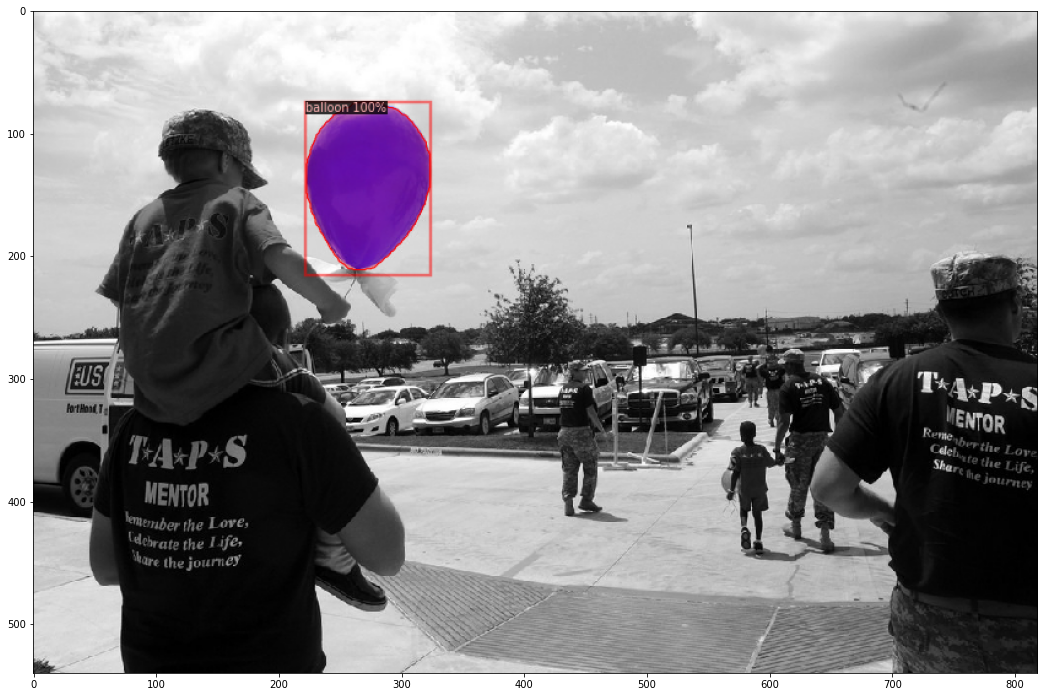

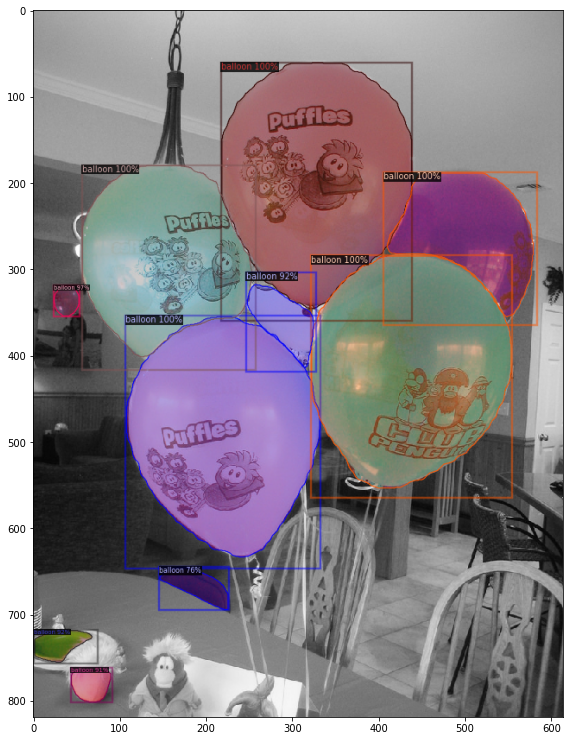

In [15]:
predictor = DefaultPredictor(cfg)
dataset_dicts = get_dataset_dicts("balloon/val")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2.imshow('Predicted', v.get_image()[:, :, ::-1])
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.imshow(v.get_image()[..., ::-1])

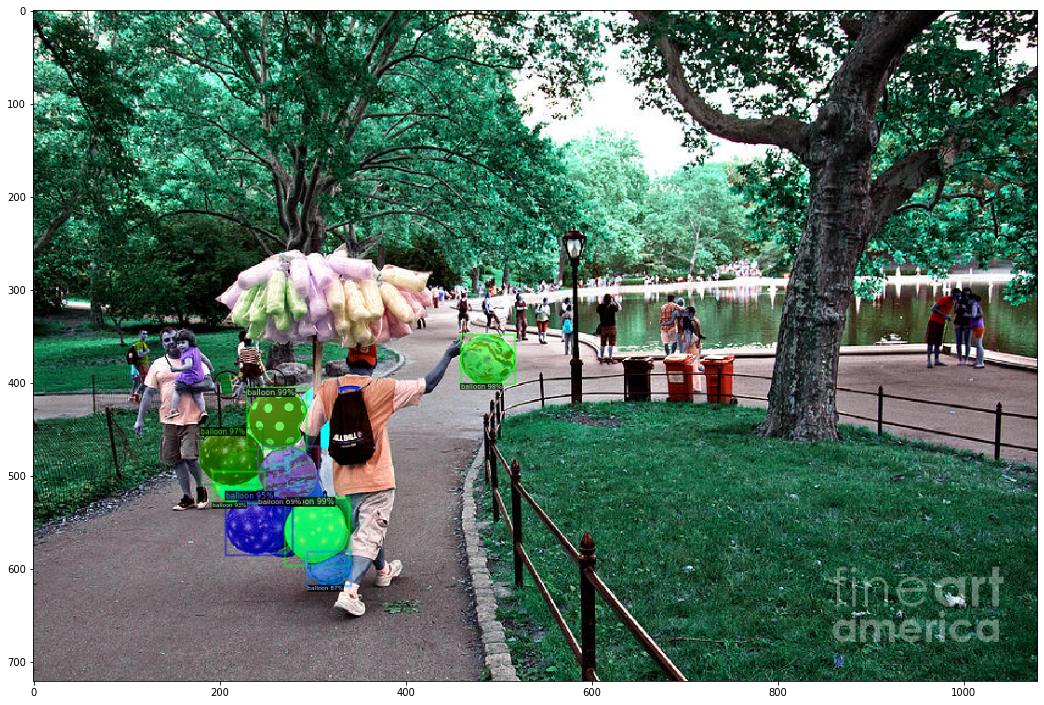

In [16]:
im = cv2.imread("central-park-balloon-man-madeline-ellis.jpg")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
plot_predict(cfg, im)

End of Notebook